In [1]:
#!/usr/bin/env python

'''
GA Data Science Q2 2016

Code walk-through 9: Logistic regression using scikit-learn

* Logistic regression
* Confusion matrix and performance metrics
* Visualising the effect of covariates
* ROC analysis
* Cross-validation
* Regularisation
* Variable (feature) selection
* Multiple classes
* Stochastic gradient descent
'''

import numpy as np
import pandas as pd

from sklearn import linear_model as lm, metrics, cross_validation as cv,\
                    grid_search, feature_selection, preprocessing

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [36]:
# Original publication: http://dx.doi.org/10.1371/journal.pone.0137524
# Dataset: http://dx.doi.org/10.5061/dryad.8jq92

#GLIOMA_URL = 'http://datadryad.org/bitstream/handle/10255/dryad.88928/An%20eighteen%20serum%20cytokine%20signature%20for%20discriminating%20glioma%20from%20normal%20healthy%20individuals%20raw%20data.xlsx?sequence=1'

glioma = pd.read_excel('../../Data/glioma.xlsx')

In [37]:
# Transpose DataFrame so that measurements are in columns
glioma = glioma.transpose()

In [62]:
len(glioma)

220

In [38]:
# Set first row as column names, then drop it
glioma.columns = glioma.iloc[0]
glioma.columns.name = ''
glioma = glioma.reindex(glioma.index.drop('sample'))

In [39]:
# Extract cytokine measurements, when reading in file the data was of typestring so need to convert to numeric
X = glioma.iloc[:,1:].apply(pd.to_numeric, axis=1)

In [40]:
# Apply logarithmic transformation to each measurement, data heavily skewed so log transform
X = X.apply(np.log, axis=1)

In [41]:
# Dichotomise outcome: GBM versus rest
# 
# DA  = Diffuse Astrocytoma (grade II)
# AA  = Anaplastic Astrocytoma (grade III)
# GBM = Glioblastoma Multiforme (grade IV)
y = glioma.Type == 'GBM'

In [42]:
'''
Logistic regression
'''

# Fit the model
# NOTE: By default, sklearn uses L2 regularisation with parameter C (default = 1)
#       This cannot be disabled, but we can set C so big that it has little effect
model1 = lm.LogisticRegression(C=1e50)
model1.fit(X, y)

LogisticRegression(C=1e+50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [43]:
# Print regression coefficients
model1.intercept_

array([ 2.59949456])

In [44]:
model1.coef_

array([[  0.31989211,  -6.70177763,  20.25049367,  -4.8489631 ,
         -5.03874662,  -4.539034  ,   5.7627634 ,  -1.17598047,
          1.98843595,  -0.37443012,  19.80918351, -11.33469017,
         -9.20477673,   3.39438239,  -5.08642153,  -0.05613427,
          2.52294579,  -8.8707485 ,   0.4423501 , -15.78216613,
         -9.11475571,   6.82621874,   9.16911833, -27.69823161,
         20.1019263 ,   0.73440316,  -7.06651743,   9.7135509 ,
         -0.47771477,  -2.1365903 ,   0.1013538 ,  -3.34811956,
         -0.14641256, -10.37591714,   5.07905043,   6.40203872,
         -0.62657915,   3.5457269 ,  -5.47381159,   9.93346688,
         -0.70910501,  13.36479861,  -9.57943834,  -5.91511047,
          2.02765246,  -2.37009197,   3.74160357,  -3.18755849]])

In [45]:
# Print odds ratios
np.exp(model1.intercept_)
np.exp(model1.coef_)

array([[  1.37697919e+00,   1.22872574e-03,   6.23272054e+08,
          7.83649900e-03,   6.48186744e-03,   1.06837220e-02,
          3.18226502e+02,   3.08516339e-01,   7.30410085e+00,
          6.87681066e-01,   4.00884339e+08,   1.19510649e-05,
          1.00557915e-04,   2.97962454e+01,   6.18009567e-03,
          9.45412188e-01,   1.24652626e+01,   1.40437431e-04,
          1.55636052e+00,   1.39924040e-07,   1.10030198e-04,
          9.21699033e+02,   9.59616033e+03,   9.34998370e-13,
          5.37224321e+08,   2.08423766e+00,   8.53199271e-04,
          1.65402305e+04,   6.20199070e-01,   1.18056695e-01,
          1.10666811e+00,   3.51503901e-02,   8.63801257e-01,
          3.11742808e-05,   1.60621463e+02,   6.03073280e+02,
          5.34416840e-01,   3.46648739e+01,   4.19521122e-03,
          2.06086647e+04,   4.92084410e-01,   6.37174356e+05,
          6.91357679e-05,   2.69836170e-03,   7.59623292e+00,
          9.34721294e-02,   4.21655514e+01,   4.12725152e-02]])

In [46]:
'''
Confusion matrix and performance metrics
'''
# Top right, failing to refer this amount of epople who have cancer and bottom left; people we flag who don't have cancer
# Confusion matrix
metrics.confusion_matrix(y, model1.predict(X))

array([[ 72,   0],
       [  0, 148]])

In [47]:
# Classification accuracy
metrics.accuracy_score(y, model1.predict(X))

1.0

In [48]:
# Classification report
print(metrics.classification_report(y, model1.predict(X)))

             precision    recall  f1-score   support

      False       1.00      1.00      1.00        72
       True       1.00      1.00      1.00       148

avg / total       1.00      1.00      1.00       220



In [49]:
# when have varibale that is not continuious, you have to convert to dummy, 
#but sklearn doesn't do this automatically so need to get_dummiesfrom pd

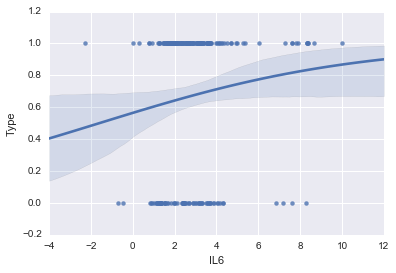

In [50]:
'''
Visualising the effect of covariates
'''

# Scatter plot of IL-6 with regression line
sns.regplot(X['IL6'], y, logistic=True)

In [51]:
# Define a set of evenly spaced IL-6 levels
# Create fake il6 values, different so we can plot them
il6_levels = np.linspace(8, 12, 100)

In [52]:
# Create a new array and fill it with:
# * the IL-6 levels defined above
# * the average observed concentrations of all other cytokines in controls
# empyt matix, put values I simulated above or just the mean of the variables
X2 = np.zeros((il6_levels.size, X.shape[1]))

for i in range(X.shape[1]):
    if i == np.where(X.columns == 'IL6')[0][0]:
        X2[:,i] = il6_levels
    else:
        X2[:,i] = X.ix[y == 0,i].mean()

In [55]:
# Compute predicted probabilities for GBM (y = 1) using the new array
# predict proba automatically returns probaility
# predict returns odd, predict log_proba you have to take exponential
# population avaergae for all other variables and then changing IL6 levels to see its effect i.e. if everything was avergage
# whats the impact of a single variable
# predict proa returns 2 sets of probability, one for each type of binary outcome
il6_pred_probs = model1.predict_proba(X2)[:,1]

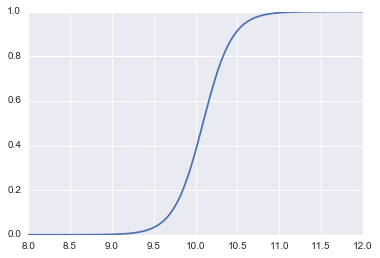

In [54]:
# Plot against IL-6 levels
plt.plot(il6_levels, il6_pred_probs)

In [57]:
'''
ROC analysis, sensitivyt plotted again specificity 
'''

# Compute predicted probabilities for GBM (y = 1)
pred_probs = model1.predict_proba(X)[:,1]
pred_probs

array([  1.24743723e-22,   3.33526819e-04,   7.46648669e-04,
         5.08071668e-28,   4.42085864e-09,   9.50096079e-09,
         1.64185967e-26,   1.48734177e-04,   5.34603935e-12,
         5.75301936e-28,   5.33566065e-09,   1.01746458e-03,
         1.10643657e-13,   1.99182130e-37,   6.16268679e-04,
         6.34988265e-14,   1.19017042e-23,   2.87052240e-11,
         7.74959844e-20,   4.64871761e-04,   1.66591709e-04,
         2.80604310e-15,   1.15460023e-03,   2.43955796e-05,
         9.75710971e-34,   3.22617685e-30,   4.29480557e-60,
         1.37432246e-44,   3.21143529e-40,   2.88929415e-04,
         3.90833196e-53,   2.31643910e-09,   6.06988125e-04,
         5.79594206e-15,   3.91766832e-04,   2.85293453e-17,
         1.15530127e-30,   6.70469131e-07,   9.46461486e-14,
         4.09276568e-12,   2.90287318e-04,   2.07601370e-24,
         2.60642203e-25,   1.06144730e-09,   1.29043959e-55,
         1.44324619e-15,   9.99999059e-01,   1.00000000e+00,
         9.99903311e-01,

In [59]:
# Confirm that model predictions assume a 50% cut-off value
# anything above 50% has brain cancer this is equivelnt to model prediction, below does not
assert(np.all((pred_probs >= 0.5) == model1.predict(X)))

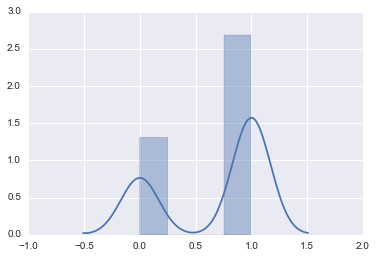

In [60]:
# Visualise distribution
# plotting 220 predicted cases in the model
sns.distplot(pred_probs)

In [61]:
# Define a set of cut-off values where sensitivity and specificity will be computed; every 1000 points
# ROC cureve graph, if you never accept anyone to have bc then top right but if you have a low acceptance criteria i.e
# sensitivity = 0, specificity = 1, then bottom left
cutoffs = np.linspace(0, 1, 1001)

In [66]:
# Define a function to compute specificity
def specificity_score(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

In [67]:
# Compute sensitivity and specificity at the cut-off values defined above
sensitivities = np.zeros(cutoffs.size)
specificities = np.zeros(cutoffs.size)
for i, cutoff in enumerate(cutoffs):
    sensitivities[i] = metrics.recall_score(y, pred_probs >= cutoff)
    specificities[i] = specificity_score(y, pred_probs >= cutoff)

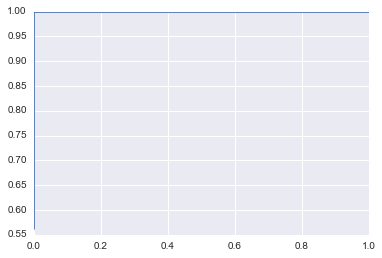

In [68]:
# Plot the ROC curve, i.e. sensitivity versus (1 - specificity)
# if you want to be more willing to accept more false posities i.e. falsely flag people who dont have cancer 
# you can changethis level by pred_probs>=0.05
#then lower sensitvty and higher specificty
plt.plot(1 - specificities, sensitivities)

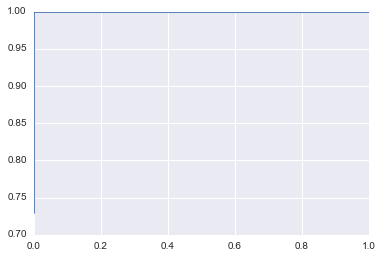

In [69]:
# Alternatively…
# (FPR = 1 - specificity; TPR = sensitivity)
fpr, tpr, cutoffs = metrics.roc_curve(y, pred_probs)
plt.plot(fpr, tpr)

In [70]:
# Compute area under the ROC curve (AUC)
metrics.roc_auc_score(y, pred_probs)

1.0

In [71]:
'''
Cross-validation
'''

# Define stratified folds
kf = cv.StratifiedKFold(y, n_folds=5, shuffle=True)

# Compute average classification accuracy across folds
accuracies = cv.cross_val_score(lm.LogisticRegression(C=1e50),\
                                X, y, scoring='accuracy', cv=kf)
np.mean(accuracies)

0.83659619450317124

In [72]:
#looking at the accuracies per fold
accuracies

array([ 0.8       ,  0.8       ,  0.93181818,  0.81395349,  0.8372093 ])

In [73]:
# Compute average AUC across folds
# change scoring to see area undeer curve
aucs = cv.cross_val_score(lm.LogisticRegression(C=1e50),\
                          X, y, scoring='roc_auc', cv=kf)
np.mean(aucs)

0.92791680350301031

In [74]:
'''
Regularisation
'''
# minimise error, and add penalty (alpha) through regularisation, penalty depends on regression coefficent; so increases
# with higher number of variables L1 Absolute error, L2 squared error
# in sklearn alpha = 1/c, so if C is big alpha goes to zero
# change scoring dependant on problem, in this problem assuming fp and fn have the same cost so finding best AUC
# but could be anything such as accuracy

# Determine ‘optimal’ value of C by cross-validation using AUC scoring
# (sklearn uses L2 regularisation by default)
Cs = np.logspace(-4, 4, 10)
gs = grid_search.GridSearchCV(
    estimator=lm.LogisticRegression(),
    param_grid={'C': Cs},
    scoring='roc_auc',
    cv=kf
)
gs.fit(X, y)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[False False ..., False False], n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   7.74264e-04,   5.99484e-03,   4.64159e-02,
         3.59381e-01,   2.78256e+00,   2.15443e+01,   1.66810e+02,
         1.29155e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [75]:
gs.best_score_

0.95607254814151366

In [76]:
gs.best_estimator_

LogisticRegression(C=0.35938136638046259, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [77]:
gs.grid_scores_

[mean: 0.63999, std: 0.07745, params: {'C': 0.0001},
 mean: 0.82632, std: 0.06278, params: {'C': 0.00077426368268112698},
 mean: 0.91811, std: 0.01084, params: {'C': 0.0059948425031894088},
 mean: 0.94983, std: 0.00582, params: {'C': 0.046415888336127774},
 mean: 0.95607, std: 0.01082, params: {'C': 0.35938136638046259},
 mean: 0.95167, std: 0.01935, params: {'C': 2.7825594022071258},
 mean: 0.94025, std: 0.02175, params: {'C': 21.544346900318821},
 mean: 0.93411, std: 0.02363, params: {'C': 166.81005372000558},
 mean: 0.93173, std: 0.02330, params: {'C': 1291.5496650148827},
 mean: 0.92981, std: 0.02352, params: {'C': 10000.0}]

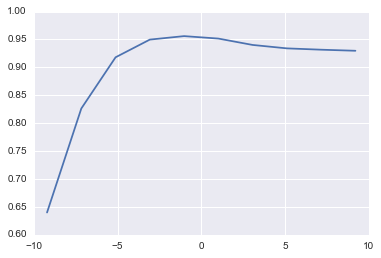

In [78]:
# Plot Cs against AUC scores
# when c is 0.36 very high AUC, bottom is lot of regularisation (when c is close to zero)
# 
plt.plot(np.log(Cs), [ x[1] for x in gs.grid_scores_ ])

In [80]:
# the same but how many values of c you have to specify
# Alternatively…
model2 = lm.LogisticRegressionCV(Cs=10, cv=kf, scoring='roc_auc')
model2.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None,
           cv=sklearn.cross_validation.StratifiedKFold(labels=[False False ..., False False], n_folds=5, shuffle=True, random_state=None),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring='roc_auc',
           solver='lbfgs', tol=0.0001, verbose=0)

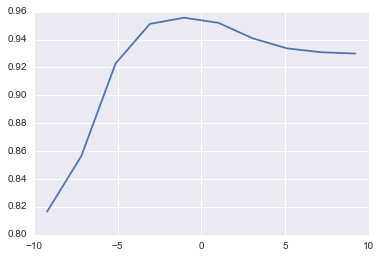

In [81]:
plt.plot(np.log(model2.Cs_), model2.scores_[1].mean(axis=0))

In [82]:
# coef shrunk because of regularisation but coef is bigger when no reg
np.exp(model2.intercept_)

array([ 1.909571])

In [83]:
np.exp(model2.coef_)

array([[ 0.61937935,  0.65970176,  1.68279767,  0.74620781,  0.65750426,
         0.58918657,  1.81100455,  1.029602  ,  0.91874712,  0.8762423 ,
         2.47130493,  0.54808875,  0.60587024,  1.09098089,  1.15350863,
         1.11847019,  1.25681012,  0.6591393 ,  1.08319256,  0.55606998,
         0.5293357 ,  0.99901545,  1.2603946 ,  0.45506919,  3.59973316,
         1.29937416,  0.71286082,  0.80718734,  1.47584398,  0.75161668,
         0.75861217,  0.80370652,  0.97659562,  1.06596736,  1.12042637,
         1.83763842,  0.99742648,  1.18737894,  0.75801339,  1.93020638,
         0.76945572,  1.4429808 ,  0.66739466,  0.7431873 ,  1.16255647,
         0.98810301,  1.61301075,  0.86043096]])

In [ ]:
# Notice above no variables are excluded although some close to zero, but L1 is more of a variable selction technique

In [84]:
# Repeat using L1 regularisation
# sklearn relies on external libraries to help solve L2 penalties
# L1 less smooth
model3 = lm.LogisticRegressionCV(Cs=10, cv=kf, penalty='l1', scoring='roc_auc',\
                                 solver='liblinear')
model3.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None,
           cv=sklearn.cross_validation.StratifiedKFold(labels=[False False ..., False False], n_folds=5, shuffle=True, random_state=None),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l1',
           random_state=None, refit=True, scoring='roc_auc',
           solver='liblinear', tol=0.0001, verbose=0)

In [85]:
np.exp(model3.intercept_)

array([ 1.])

In [86]:
np.exp(model3.coef_)

array([[  0.55322399,   0.88198417,  17.57388689,   0.54107955,
          0.3642632 ,   0.711782  ,   2.59987976,   1.        ,
          1.        ,   0.82723465,  15.37085438,   0.1644772 ,
          0.26818522,   1.32704451,   1.        ,   1.        ,
          1.6653661 ,   0.39195309,   1.03644071,   0.04229967,
          0.30128888,   1.11849438,   2.94281176,   0.02396951,
         22.91794575,   1.        ,   0.47064559,   1.14472027,
          1.02973992,   0.56478239,   1.        ,   0.66564486,
          0.88386031,   0.49584944,   1.        ,   3.05795376,
          1.        ,   1.36499849,   0.48568822,   4.98152814,
          0.62949843,   9.68975087,   0.48522305,   0.55777404,
          1.40286063,   1.        ,   2.55623111,   0.51284496]])

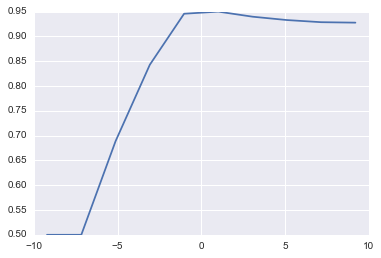

In [87]:
plt.plot(np.log(model3.Cs_), model3.scores_[1].mean(axis=0))

In [90]:
'''
Variable (feature) selection
'''

# Select only variables with non-zero coefficient in L1-regularised model
# checking where in array we don't have zeros to see what has been selected
idx = np.where(np.abs(model3.coef_[0]) >= 1e-16)[0]

#idx = np.where(np.abs(model3.coef_[0]) > 0)[0]
idx

array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 11, 12, 13, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 35, 37, 38, 39, 40, 41,
       42, 43, 44, 46, 47], dtype=int64)

In [91]:
# List selected variables
# corresponding varibales that were selected
X.columns[idx]

Index(['PDGFbb', 'IL1b', 'IL1Ra', 'IL2', 'IL4', 'IL5', 'IL6', 'IL9', 'IL10',
       'IL12P70', 'IL13', 'IL15', 'FGFbasic', 'GCSF', 'GMCSF', 'IFNg', 'IP10',
       'MCP1', 'MIP1a', 'MIP1b', 'RANTES', 'VEGF', 'CTACK', 'GROa', 'IL1a',
       'IL3', 'IL12P40', 'IL16', 'LIF', 'MCSF', 'MIF', 'MIG ', 'bNGF', 'SCF',
       'SCGFb', 'SDF1a', 'TNFb', 'HGF', 'IFNa2'],
      dtype='object', name='')

In [92]:
# Re-fit model using selected variables only
X_selected = X.iloc[:,idx]
model4 = lm.LogisticRegression(C=model3.C_[0])
model4.fit(X_selected, y)

LogisticRegression(C=2.7825594022071258, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

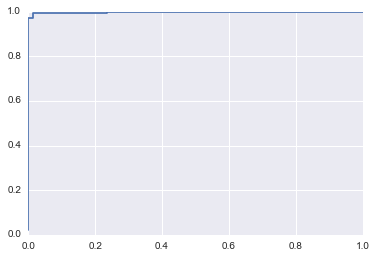

In [93]:
# Plot ROC curve
pred_probs = model4.predict_proba(X_selected)[:,1]
fpr, tpr, cutoffs = metrics.roc_curve(y, pred_probs)
plt.plot(fpr, tpr)

In [95]:
# Compute area under the ROC curve (AUC)
# one way in which regularising with L1 avoids over fitting
metrics.roc_auc_score(y, pred_probs)

0.99812312312312312

In [96]:
# Recursive Feature Elimination and Cross-Validated selection
# Another way of slecting feature/variables instead of L1,
#this starts with full model and removes certain variables, it works by cross validating AUC, remove one variabe at a time
# if the AUC doesn't go down by a certain threshold/signif amount then continue removing, just before the drop
# Feature_selection a number of methods
# (using value of C found using cross-validation above)
fs = feature_selection.RFECV(lm.LogisticRegression(C=model2.C_[0]),\
                             cv=kf, scoring='roc_auc')
fs.fit(X, y)

RFECV(cv=sklearn.cross_validation.StratifiedKFold(labels=[False False ..., False False], n_folds=5, shuffle=True, random_state=None),
   estimator=LogisticRegression(C=0.35938136638046259, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
   estimator_params=None, scoring='roc_auc', step=1, verbose=0)

In [97]:
# List selected variables
X.columns[fs.support_]

Index(['PDGFbb', 'IL1b', 'IL1Ra', 'IL2', 'IL4', 'IL5', 'IL6', 'IL8', 'IL9',
       'IL10', 'IL12P70', 'IL13', 'IL15', 'IL17', 'eotaxin', 'FGFbasic',
       'GCSF', 'GMCSF', 'IFNg', 'IP10', 'MIP1a', 'MIP1b', 'RANTES', 'TNFa',
       'VEGF', 'CTACK', 'GROa', 'IL1a', 'IL2Ra', 'IL3', 'IL16', 'IL18', 'LIF',
       'MCSF', 'MIF', 'MIG ', 'bNGF', 'SCF', 'SCGFb', 'SDF1a', 'TNFb', 'HGF',
       'IFNa2'],
      dtype='object', name='')

In [99]:
# Re-fit model using selected variables only
X_selected = X.loc[:,fs.support_]
model5 = lm.LogisticRegression(C=model2.C_[0])
model5.fit(X_selected, y)

LogisticRegression(C=0.35938136638046259, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

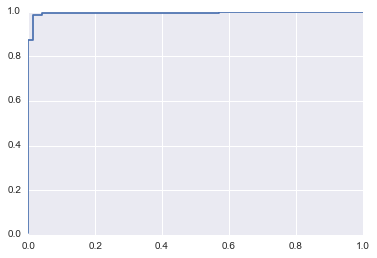

In [100]:
# Plot ROC curve
pred_probs = model5.predict_proba(X_selected)[:,1]
fpr, tpr, cutoffs = metrics.roc_curve(y, pred_probs)
plt.plot(fpr, tpr)

In [101]:
# Compute area under the ROC curve (AUC)
metrics.roc_auc_score(y, pred_probs)

0.99427552552552545

In [107]:
'''
Multiple classes
'''

# Check the argument `multi_class`:
# * 'ovr' means that binary models are estimated for each class; doesn't acount for all data it is just one group against rest
# * 'multinomial' means that a single multinomial model is estimated; same concept as logistic just for multi class
# need to change solver for this; the only solver which supports this is lbfgs
# again C needs to be tuned

# For example…
model6 = lm.LogisticRegression(C=1e50, solver='lbfgs', multi_class='multinomial')
model6.fit(X, glioma.Type)

LogisticRegression(C=1e+50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [104]:
# Important to see order when interpreting coefficients
model6.classes_

array(['AA', 'DA', 'GBM', 'Normal'], dtype=object)

In [105]:
# Coefficent are big matrix
np.exp(model6.intercept_)

array([ 0.36522699,  1.41257233,  1.78198778,  1.08773154])

In [106]:
np.exp(model6.coef_)

array([[  1.66401726e+02,   1.18641178e+15,   6.72837192e-10,
          5.17807081e+23,   4.41657577e+35,   1.36805607e+33,
          1.49279834e-07,   6.84351762e-01,   5.39910494e+07,
          3.36770293e+10,   1.60336775e+00,   2.86084385e+04,
          2.14581254e+07,   9.62547665e+23,   8.02835925e+42,
          6.55992447e-25,   4.90636868e-01,   3.16727872e+44,
          7.40935244e+00,   1.99685318e+25,   2.33158219e+28,
          3.20371504e-06,   1.54175097e+10,   4.59554827e-10,
          3.49498019e-51,   5.53607340e-15,   1.61190510e+18,
          4.01450038e+06,   2.33929784e-05,   3.17044440e-12,
          1.95681523e+08,   2.67821824e-04,   1.13089824e-16,
          4.25698588e-09,   1.57927742e+02,   1.50714410e+00,
          2.67331447e-14,   1.27094588e-06,   5.66835635e+00,
          4.04785410e-17,   1.51457418e-06,   8.53834783e-02,
          1.13144337e+04,   1.44769621e+00,   1.64119439e+01,
          3.93240828e-10,   1.48812212e-09,   7.35025255e-11],
       

In [ ]:
'''
Stochastic gradient descent
'''

# SGD is a very efficient approach to train linear classifiers (including linear
# and logistic regression models) on large-scale and/or sparse datasets
#
# scikit-learn provides:
# * `lm.SGDRegressor` for regression problems
# * `lm.SGDClassifier` for classification problems
#
# Both support L1, L2, and Elastic Net regularisation (with parameters 'alpha'
# and 'l1_ratio' if using Elastic Net)

# SGD is sensitive to scaling of the predictors, so it’s recommended to scale
# the data to [0, 1], [-1, 1], or alternatively to standardise it to mean 0 and
# variance 1, if there’s no ‘intrinsic scale’ already

In [109]:
scaler = preprocessing.StandardScaler()
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [110]:
scaler.mean_

array([  9.99539476,   0.80152791,   5.49143203,   2.25300407,
         1.22655956,   0.57600468,   2.93735028,   2.62217102,
         3.68459448,   3.64328249,   2.02278736,   3.6323892 ,
         1.79763602,   0.62891029,   3.51973225,   4.07108704,
         2.00353997,   2.61282377,   2.78812599,   4.90404526,
         6.74825218,   4.1293354 ,   1.1344134 ,   4.94605112,
         9.95577715,   2.345788  ,   4.57255829,   6.40788736,
         4.72490512,  -1.46371671,   4.5816658 ,   1.21608087,
         2.33135695,   5.46828562,   4.57949708,   1.34682936,
        -0.38750231,   2.99860097,   6.91225775,   7.0856813 ,
        -0.66243746,   4.65070043,  10.49773501,   3.33274845,
         0.240739  ,   3.27700293,   6.59564518,   2.74638321])

In [111]:
scaler.scale_

array([ 0.85143548,  1.64069792,  1.07417217,  1.93762333,  1.04239627,
        1.26939598,  1.79960077,  0.91389158,  2.1013133 ,  1.40950617,
        1.82939839,  1.19279265,  1.00660976,  1.72065524,  1.74181673,
        1.82744383,  1.3829932 ,  1.64144389,  1.88873333,  1.09001268,
        0.83853527,  1.23892079,  2.11561823,  0.90493839,  1.14403886,
        1.9719999 ,  1.03068775,  0.54101563,  1.08729502,  1.96647206,
        0.73729311,  2.3082563 ,  2.39821568,  0.98116276,  0.59024852,
        1.48595068,  2.29918577,  1.42853643,  1.41715013,  0.89480025,
        1.35575442,  0.50760289,  0.52963759,  1.47455136,  1.92442411,
        1.17256277,  0.54575914,  0.74267761])

In [112]:
X_scaled = scaler.transform(X)

In [113]:
# According to the scikit-learn documentation, the following is a good guess for
# the number of iterations required to achieve convergence
# The higher the iteration, the more likely to find global minimum.
# stochastic is all about picking different points, so you are more likely to find global
n_iter = np.ceil(10**6 / X.shape[0])

In [114]:
# As usual, the regularisation parameter 'alpha' can be tuned using
# `grid_search.GridSearchCV`
gs = grid_search.GridSearchCV(
    estimator=lm.SGDClassifier(loss='log', penalty='l2', n_iter=n_iter),
    param_grid={'alpha': 10.0**-np.arange(1, 7)},
    scoring='roc_auc',
    cv=kf
)
gs.fit(X_scaled, y)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[False False ..., False False], n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=4546.0, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-01,   1.00000e-02,   1.00000e-03,   1.00000e-04,
         1.00000e-05,   1.00000e-06])},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [115]:
gs.best_estimator_

# Before using this model to predict, we'd need to call `scaler.transform` on
# the new data

# We can also put everything together in a pipeline…

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=4546.0, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [116]:
#pipelline -> concept of steps and combine them together, combining scale and model into a pipeline
sgd_pipeline = Pipeline([
    ('scale', preprocessing.StandardScaler()),
    ('sgd', lm.SGDClassifier())
])

In [117]:
sgd_pipeline.set_params(
    sgd__loss='log',
    sgd__penalty='l2',
    sgd__n_iter=n_iter
)

Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgd', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=4546.0, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))])

In [ ]:
# Pipeline acts like a model so can do grid search on it directly without having to scale data
gs = grid_search.GridSearchCV(
    estimator=sgd_pipeline,
    param_grid={'sgd__alpha': 10.0**-np.arange(1, 7)},
    scoring='roc_auc',
    cv=kf
)
gs.fit(X, y)

In [119]:
gs.best_estimator_

# Predictions for new samples can now be obtained directly by calling
# `gs.best_estimator_.predict`



Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgd', SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=4546.0, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))])

In [120]:
# need to call on scaled data
gs.best_estimator_.predict(X_scaled)

array([ True,  True,  True, False,  True,  True, False,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False, False,  True,  True,  True, False,
       False,  True,  True, False,  True, False,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [121]:
?lm.stochastic_gradient